# Optimization of Sales

#### Imports

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
!pip install pulp
from pulp import *

## Advertising Dataset

**Some details about the dataset are given below:**

In [24]:
df = pd.read_csv("advertising.csv")

In [25]:
df

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [27]:
len(df)

200

In [28]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


In [29]:
df.mean()

TV           147.0425
Radio         23.2640
Newspaper     30.5540
Sales         15.1305
dtype: float64

- **The dataset comprises 200 data points for each of the data variables, i.e., TV, Radio, Newspaper, and Sales. Columns "TV", "Radio", and "Newspaper" have recorded data for the budget in thousands of dollars. Column "Sales" has recorded data for the sales in thousands of units.**
- **The dataset gives one the opportunity to design an optimization problem of maximizing sales around a set of assumed constraints**

#### Visualizations

**Pair plots**

*Comparing sales with each data variable*

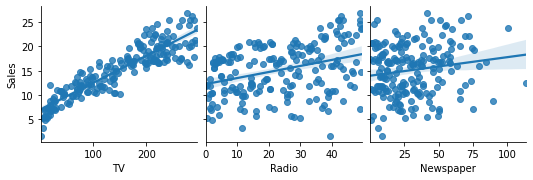

In [30]:
sb.pairplot(df, x_vars=["TV","Radio","Newspaper"],y_vars= "Sales",kind="reg")

*Comparing data variables*

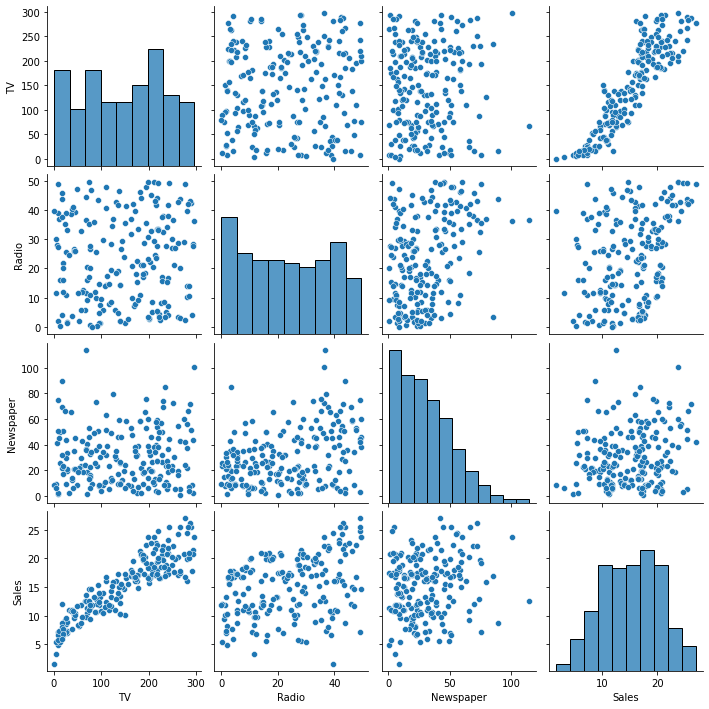

In [31]:
sb.pairplot(df);

**Correlation heatmap**

*Correlation between different variables*

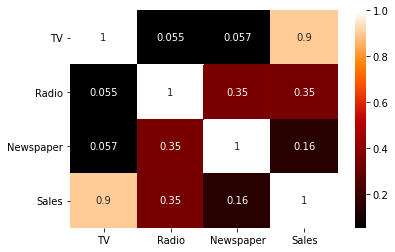

In [32]:
corr = df.corr()
sb.heatmap(corr, cmap ='gist_heat', annot =True);

**Residual plots**

*TV Vs Sales*

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


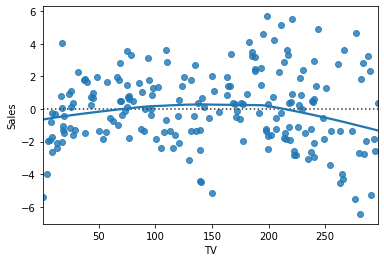

In [33]:
sb.residplot(x = df['TV'], y = df['Sales'], lowess = True);

*Radio Vs Sales*

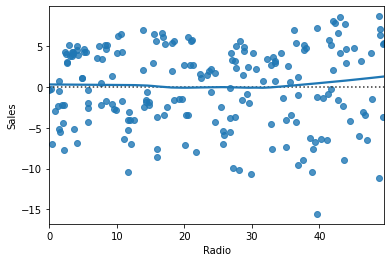

In [34]:
sb.residplot(x = df['Radio'], y = df['Sales'], lowess = True);

*Newspaper Vs Sales*

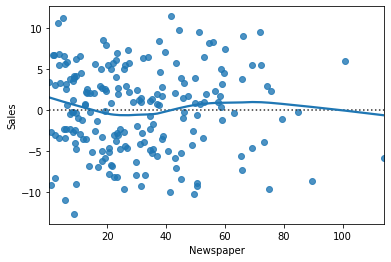

In [35]:
sb.residplot(x = df['Newspaper'], y = df['Sales'], lowess = True);

**Adding an extra column for average budget**

In [36]:
df['Average Budget'] = df[['TV', 'Radio', 'Newspaper']].mean(numeric_only=True, axis=1)
df

,TV,Radio,Newspaper,Sales,Average Budget
0,230.1,37.8,69.2,22.1,112.366667
1,44.5,39.3,45.1,10.4,42.966667
2,17.2,45.9,69.3,12.0,44.133333
3,151.5,41.3,58.5,16.5,83.766667
4,180.8,10.8,58.4,17.9,83.333333
...,...,...,...,...,...
195,38.2,3.7,13.8,7.6,18.566667
196,94.2,4.9,8.1,14.0,35.733333
197,177.0,9.3,6.4,14.8,64.233333
198,283.6,42.0,66.2,25.5,130.600000


**Scatter plot**

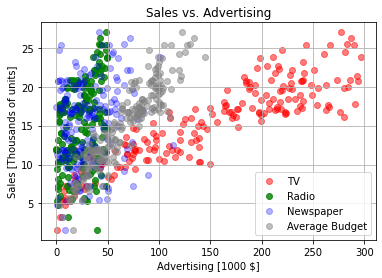

In [37]:
plt.scatter(df['TV'],df['Sales'],c="red",alpha=0.5, label='TV')
plt.scatter(df['Radio'],df['Sales'],c="green",alpha=0.8, label='Radio')
plt.scatter(df['Newspaper'],df['Sales'],c="blue",alpha=0.3, label= 'Newspaper')
plt.scatter(df['Average Budget'],df['Sales'],c="gray",alpha=0.5, label= 'Average Budget')
plt.legend(loc="lower right")
plt.title("Sales vs. Advertising")
plt.xlabel("Advertising [1000 $]")
plt.ylabel("Sales [Thousands of units]")
plt.grid()
plt.show()

#### Optimization Problem

**Problem:** 

1. A budget constraint restricting the total amount of money to be allocated among three different channels (TV, Radio, Newspaper) takes the form x1 + x2 + x3 ≤ B, where B is the budget.

2. The total spend for each of these channels (TV, Radio, Newspaper) should be less than or equal to some constraints t, r, and n while total budget is capped at B.

3. Find out the objective function where we plan to maximize or minimize sales etc).


**Approach:** 

1. Set constraint limits to variables B (total budget), t (TV), r (Radio), and Newspaper (n).

2. Build a linear regression model using the set constraints and data. Construct an objective function from the acquired results.

3. Maximize or Minimize for a desired output using linear programming (use python's PuLP.

In [38]:
y = df['Sales']
x = df[['Average Budget']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

**Linear Regression**

In [39]:
regression = LinearRegression()
regression.fit(x_train,y_train)
rgs_y_pred = regression.predict(x_test)
rgs_score = regression.score(x_test, y_test)
rgs_MSE = np.sqrt(mean_squared_error(y_test,rgs_y_pred))
rgs_coef = regression.coef_
rgs_intercept = regression.intercept_
print("Score: ", rgs_score)
print("Error: ", rgs_MSE)
print("coef: ",rgs_coef)
print("intercept: ",rgs_intercept)

Score:  0.8456556633464667
Error:  2.2697402281440273
coef:  [0.15338209]
intercept:  4.924012999480922


**Lasso Model**

In [40]:
lasso = Lasso(alpha= 0.01)
lasso.fit(x_train,y_train)
lss_y_pred = lasso.predict(x_test)
lss_score = lasso.score(x_test, y_test)
lss_MSE = np.sqrt(mean_squared_error(y_test,lss_y_pred))
lss_coef = lasso.coef_
lss_intercept = lasso.intercept_
print("Score: ", lss_score)
print("Error: ", lss_MSE)
print("coef: ",lss_coef)
print("intercept: ",lss_intercept)

Score:  0.845642518821921
Error:  2.2698368757490126
coef:  [0.15337158]
intercept:  4.924728279503103


**Ridge Model**

In [41]:
rr = Ridge(alpha=0.01)
rr.fit(x_train, y_train) 
rr_y_pred= rr.predict(x_test)
rr_score = rr.score(x_test, y_test)
rr_MSE = np.sqrt(mean_squared_error(y_test,rr_y_pred))
rr_coef = rr.coef_
rr_intercept = rr.intercept_
print("Score: ", rr_score)
print("Error: ", rr_MSE)
print("coef: ",rr_coef)
print("intercept: ",rr_intercept)

Score:  0.8456556507487415
Error:  2.2697403207731566
coef:  [0.15338208]
intercept:  4.924013685175543


**Elastic Net**

In [42]:
enet = ElasticNet(alpha = 0.01)
enet.fit(x_train, y_train) 
enet_y_pred = enet.predict(x_test)
enet_score = enet.score(x_test, y_test)
enet_MSE = np.sqrt(mean_squared_error(y_test,enet_y_pred))
enet_coef = enet.coef_
enet_intercept = enet.intercept_
print("Score: ", enet_score)
print("Error: ", enet_MSE)
print("coef: ",enet_coef)
print("intercept: ",enet_intercept)

Score:  0.8456480838509213
Error:  2.2697959583221503
coef:  [0.15337603]
intercept:  4.924425492896276


In [43]:
avg_coef = (rgs_coef+lss_coef+rr_coef+enet_coef)/4
avg_intercept = (rgs_intercept+lss_intercept+rr_intercept+enet_intercept)/4
print(avg_coef)
print(avg_intercept)

[0.15337794]
4.924295114263961


**Constraints:**

Let the constraint on the total budget B be 1000, i.e., (T+R+N) <= 1000.

Let the constraint on each of the channels be as follows:
T <= 200
R <= 500
N <= 500

*Objective Function to Maximize Sales using PuLP*

Maximize Sales, S = 0.05367932(T) + 0.11150177(R) - 0.0034977(N) + 4.773466912078015

In [44]:
OpProb = LpProblem("AdvsSalesOpt", LpMaximize)
T = LpVariable("TV", 0, 200)
R = LpVariable("Radio", 0, 500)
N = LpVariable("Newspaper", 0, 500)
OpProb += T + R + N <= 1000
OpProb +=  0.05367932*T + 0.11150177*R - 0.0034977*N + 4.773466912078015
status = OpProb.solve()
LpStatus[status]

'Optimal'

In [45]:
print(OpProb)
for v in OpProb.variables():
    print(v.name, "=", v.varValue)

AdvsSalesOpt:
MAXIMIZE
-0.0034977*Newspaper + 0.11150177*Radio + 0.05367932*TV + 4.773466912078015
SUBJECT TO
_C1: Newspaper + Radio + TV <= 1000

VARIABLES
Newspaper <= 500 Continuous
Radio <= 500 Continuous
TV <= 200 Continuous

Newspaper = 0.0
Radio = 500.0
TV = 200.0


In [46]:
print("Objective Value = %f" % (OpProb.objective.value()))


Objective Value = 71.260216


In [47]:
# Optimized Value for Sales, Confirmation through calculation

OptVal = 0.05368006*200 + 0.11152624*500 - 0.00351166*0 + 4.773205203269837
print("Optimized Budget Sales: ",OptVal)

Optimized Budget Sales:  71.27233720326984


**Trying with Different Budget Limits**

In [48]:
for i in range(1,6):
    OpProb = LpProblem("AdvsSalesOpt", LpMaximize)
    it = i*200
    ir = i*500
    inw = i*500
    T = LpVariable("TV", 0, it)
    R = LpVariable("Radio", 0, ir)
    N = LpVariable("Newspaper", 0, inw)
    sum = it + ir +inw
    OpProb += T + R + N <= sum
    OpProb +=  0.05367932*T + 0.11150177*R - 0.0034977*N + 4.773466912078015
    status = OpProb.solve()
    j = 1
    print(OpProb)
    for v in OpProb.variables():
        print(v.name, "=", v.varValue)
    print("Objective Value = %f" % (OpProb.objective.value()))
    print("--------------------------------------------------")
    print("--------------------------------------------------")

AdvsSalesOpt:
MAXIMIZE
-0.0034977*Newspaper + 0.11150177*Radio + 0.05367932*TV + 4.773466912078015
SUBJECT TO
_C1: Newspaper + Radio + TV <= 1200

VARIABLES
Newspaper <= 500 Continuous
Radio <= 500 Continuous
TV <= 200 Continuous

Newspaper = 0.0
Radio = 500.0
TV = 200.0
Objective Value = 71.260216
--------------------------------------------------
--------------------------------------------------
AdvsSalesOpt:
MAXIMIZE
-0.0034977*Newspaper + 0.11150177*Radio + 0.05367932*TV + 4.773466912078015
SUBJECT TO
_C1: Newspaper + Radio + TV <= 2400

VARIABLES
Newspaper <= 1000 Continuous
Radio <= 1000 Continuous
TV <= 400 Continuous

Newspaper = 0.0
Radio = 1000.0
TV = 400.0
Objective Value = 137.746965
--------------------------------------------------
--------------------------------------------------
AdvsSalesOpt:
MAXIMIZE
-0.0034977*Newspaper + 0.11150177*Radio + 0.05367932*TV + 4.773466912078015
SUBJECT TO
_C1: Newspaper + Radio + TV <= 3600

VARIABLES
Newspaper <= 1500 Continuous
Radio 

**Optimizing for User Given Budget Limits**

In [49]:
LT = int(input("Enter Budget Limit for TV ads = "))
LR = int(input("Enter Budget Limit for Raido ads = "))
LN = int(input("Enter Budget Limit for Newspaper ads = "))
Total = LT+LR+LN
print("Company`s total ads investment = ",Total)
print("\n\nOptimizing Sales for given budget")
OpProb = LpProblem("AdvsSalesOpt", LpMaximize)
T = LpVariable("TV", 0, LT)
R = LpVariable("Radio", 0, LR)
N = LpVariable("Newspaper", 0, LN)
OpProb += T + R + N <= Total
OpProb +=  0.05367932*T + 0.11150177*R - 0.0034977*N + 4.773466912078015
status = OpProb.solve()
print(OpProb)
for v in OpProb.variables():
  print(v.name, "=", v.varValue)
print("Objective Value = %f" % (OpProb.objective.value()))

Enter Budget Limit for TV ads = 500
Enter Budget Limit for Raido ads = 800
Enter Budget Limit for Newspaper ads = 200
Company`s total ads investment =  1500


Optimizing Sales for given budget
AdvsSalesOpt:
MAXIMIZE
-0.0034977*Newspaper + 0.11150177*Radio + 0.05367932*TV + 4.773466912078015
SUBJECT TO
_C1: Newspaper + Radio + TV <= 1500

VARIABLES
Newspaper <= 200 Continuous
Radio <= 800 Continuous
TV <= 500 Continuous

Newspaper = 0.0
Radio = 800.0
TV = 500.0
Objective Value = 120.814543
